In [190]:
import numpy as np
import matplotlib.pyplot as plt
import gdal
import cv2

gdal.AllRegister()
plt.rcParams['figure.figsize'] = [10, 5]

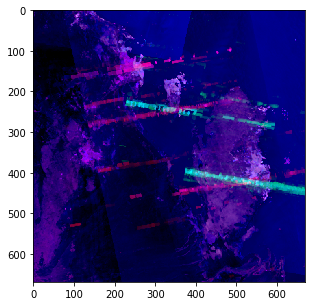

In [191]:
# Load data from tif file
ds = gdal.Open('./data/vhExportSmallMax.tif')
vh_band = ds.GetRasterBand(1)
vh = vh_band.ReadAsArray()
vh1_band = ds.GetRasterBand(2)
vh1 = vh1_band.ReadAsArray()
vv_band = ds.GetRasterBand(3)
vv = vv_band.ReadAsArray()

# Strip NaNs (I think these appear where data is redacted)
vh[np.isnan(vh)]=np.median(vh[np.isfinite(vh)])-np.std(vh[np.isfinite(vh)])
vh1[np.isnan(vh1)]=np.median(vh1[np.isfinite(vh1)])-np.std(vh1[np.isfinite(vh1)])
vv[np.isnan(vv)]=np.median(vv[np.isfinite(vv)])-np.std(vv[np.isfinite(vv)])

# Apply the upper and lower cutoffs that Harel Dan applied
vh[vh < -25] = -25
vh[vh > 0] = 0
vh1[vh1 < -20] = -20
vh1[vh1 > 10] = 10
vv[vv < -25] = -25
vv[vv > 0] = 0

# Scale to [0, 255]
vh = vh - np.min(vh)
vh = vh / np.max(vh) * 255
vh1 = vh1 - np.min(vh1)
vh1 = vh1 / np.max(vh1) * 255
vv = vv - np.min(vv)
vv = vv / np.max(vv) * 255

# Plot
img = np.zeros([vh.shape[0],vh.shape[1],3])
img[:,:,0] = vh
img[:,:,1] = vh1
img[:,:,2] = vv
r,g,b = cv2.split(img)
rgb = cv2.merge([r, g, b])
rgb = rgb.astype(np.uint8)
plt.imshow(rgb)
plt.savefig('img.png', dpi=600)

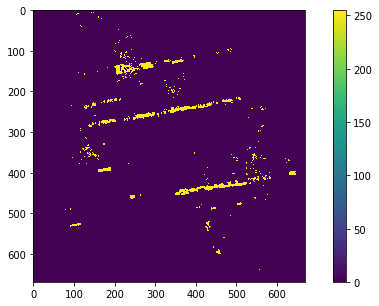

In [230]:
red_m = cv2.inRange(rgb, np.array([110, 0, 0]), np.array([255, 200, 200]))
plt.imshow(red_m)
cbar = plt.colorbar()

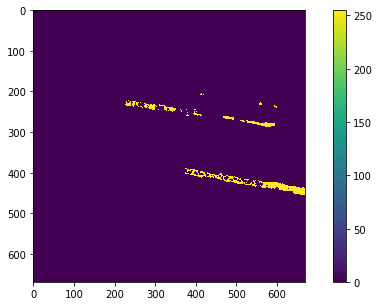

In [231]:
green_m = cv2.inRange(rgb, np.array([0, 120, 0]), np.array([200, 255, 200]))
plt.imshow(green_m)
cbar = plt.colorbar()

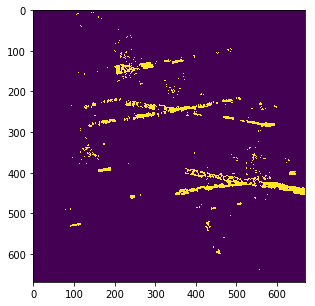

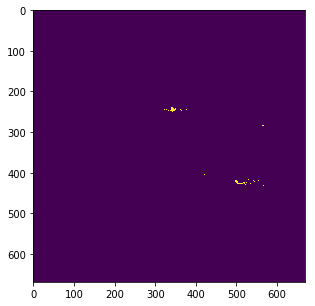

In [232]:
intersection = np.logical_and(green_m, red_m)
union = np.logical_or(green_m, red_m)

plt.imshow(union)
plt.show()

plt.imshow(intersection)
plt.show()